# Tutorial for Python users

In this tutorial we will enrich Acropora digitifera observations with bathymetry information.
Please make sure you already followed the [installation instructions](https://geoenrich.readthedocs.io/en/latest/install.html).

We will first load the occurence file and create an *enrichment file*. As we download environment data, necessary metadata will be saved into that file.

Afterwards, we will pick a variable id from the [catalog](https://geoenrich.readthedocs.io/en/latest/variables.html), and start downloading bathymetry data.

Finally, we will visualize the result for one of the occurrences.

## Load your occurrence data

In [ ]:
import os
from geoenrich.dataloader import *
from geoenrich.enrichment import create_enrichment_file

#### If you are using your own dataset (DarwinCore format)

A DarwinCore archive is bundled into the package for user testing (GBIF Occurrence Download [10.15468/dl.megb8n](https://doi.org/10.15468/dl.megb8n)).

If you don't have a dataset and you don't want to register to GBIF yet you can use this one.

In [ ]:
example_path = os.path.split(geoenrich.__file__)[0] + '/data/AcDigitifera.zip'
geodf = open_dwca(path = example_path)

#### If you are using your own dataset (csv format)

Fill in the path to your csv and the compulsory column names.

Additional arguments are passed down to pandas.read_csv

In [ ]:
geodf = import_csv(path = '', id_col = '', date_col = '', lat_col = '',
                           lon_col = '', depth_col = '')

#### If you do not have occurrences but want to enrich arbitrary areas

See [documentation](https://geoenrich.readthedocs.io/en/latest/dataloader.html#geoenrich.dataloader.load_areas_file) for information about input file format.

In [ ]:
example_path = os.path.split(geoenrich.__file__)[0]  + '/data/areas.csv'
df = load_areas_file(example_path)

#### Create enrichment file

In [ ]:
# For occurrences
dataset_ref_occ = 'ac_digitifera'
create_enrichment_file(geodf, dataset_ref_occ)

In [ ]:
# For areas
dataset_ref_areas = 'arbitrary_areas'
create_enrichment_file(df, dataset_ref_areas)

## Enrich

In [ ]:
from geoenrich.enrichment import enrich

#### Define enrichment scope

We use the dataset reference that was used to create the enrichment file.

geo_buff is the buffer around the occurences (in kilometers).

time_buff specifies a temporal buffer. In this case we download data from 7 days before the occurrence date, to the occurrence date. time_buff is only used for variables that have a time dimension

In [ ]:
var_id = 'bathymetry'
dataset_ref_occ = 'ac_digitifera'
geo_buff = 115
time_buff = (-7, 0)

#### Only enrich a small slice first to check speed.

In [ ]:
enrich(dataset_ref_occ, var_id, geo_buff, time_buff, slice = (0, 100))

#### For large areas, use downsample argument to download only part of available data (to reduce download time)

In [ ]:
# Skip 9 latitude and longitude points for every downloaded point.
dataset_ref_areas = 'arbitrary_areas'
downsample = {'latitude': 9, 'longitude': 9}

enrich(dataset_ref_areas, var_id, downsample = downsample)

## Data retrieval

In [2]:
from geoenrich.enrichment import read_ids, enrichment_status
from geoenrich.exports import *
dataset_ref = 'ac_digitifera'
var_id = 'bathymetry'

#### Check the enrichment status of the dataset.

In [ ]:
enrichment_status(dataset_ref)

#### Export summary statistics to a csv file

In [ ]:
produce_stats(dataset_ref, var_id, out_path = './')

#### Export data as a png file for the first occurrence of the dataset

In [4]:
ids = read_ids(dataset_ref)
occ_id = ids[0]

In [ ]:
export_png(dataset_ref, occ_id, var_id, path = '')

#### Retrieve the raw data and plot it

In [6]:
output = retrieve_data(dataset_ref, occ_id, var_id, shape = 'buffer')

data = output['values']
unit = output['unit']
coords = output['coords']

<IPython.core.display.Javascript object>


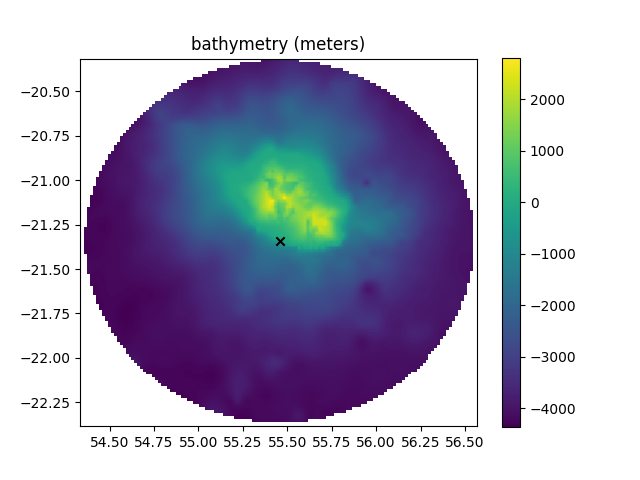

In [8]:
from shapely import wkt
from matplotlib import pyplot as plt
%matplotlib notebook

# Get latitude and longitude values for the requested data
lat_dim = [c[0] for c in coords].index('latitude')
lon_dim = [c[0] for c in coords].index('longitude')
lats = coords[lat_dim][1]
longs = coords[lon_dim][1]

# Get coordinates for the occurrence point
filepath = biodiv_path + dataset_ref + '.csv'
df = pd.read_csv(filepath, parse_dates = ['eventDate'], infer_datetime_format = True, index_col = 0)
point = wkt.loads(df.loc[occ_id, 'geometry'])

# Plot
extent = [longs[0] , longs[-1], lats[0] , lats[-1]]
plt.imshow(data, extent = extent, origin = 'lower')
plt.title(var_id + ' (' + unit + ')')
plt.colorbar()
plt.scatter([point.x], [point.y], c='black', marker='x')

# NB: If your data has time or depth dimensions, you will have to pick a slice of the data array to be able to plot it

## Using occurrence data from GBIF

You may want to use occurrences from GBIF. GeoEnrich provides a few functions to easily download occurrences for any taxon, relying on the pygbif package.

In [ ]:
from geoenrich.dataloader import *

#### Get GBIF id for the taxon of interest

In [ ]:
tax_key = get_taxon_key('Acropora digitifera')

#### Request an archive with all occurrences of this taxon

In [ ]:
request_id = request_from_gbif(tax_key)

#### Download request

For large requests, some waiting time is needed for the archive to be ready.

In [ ]:
download_requested(request_key = request_id)

#### You can then load data using open_dwca and the taxon_key parameter

In [ ]:
geodf = open_dwca(taxon_key = tax_key)

You can then create an enrichment file just like with any other dataset (see first section of the tutorial).